In [1]:
import keras
keras.__version__

/usr/lib64/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.2.4'

In [2]:
from keras.applications import VGG16

In [3]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [5]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [6]:
base_dir = './datasets/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [7]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [9]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) # 정의한 모델의 최종 OUTPUT SHAPE -> (None, 4, 4, 512)
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # 제너레이터는 루프 안에서 무한하게 데이터를 만들어내므로 모든 이미지를 한 번씩 처리하고 나면 중지합니다
            break
    return features, labels

In [10]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [12]:
from keras import models
from keras import layers
from keras import optimizers

In [13]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 853us/step - loss: 0.5495 - acc: 0.7240 - val_loss: 0.4204 - val_acc: 0.8310
Epoch 2/30
2000/2000 [==============================] - 1s 404us/step - loss: 0.3839 - acc: 0.8410 - val_loss: 0.3502 - val_acc: 0.8390
Epoch 3/30
2000/2000 [==============================] - 1s 310us/step - loss: 0.3232 - acc: 0.8735 - val_loss: 0.3011 - val_acc: 0.8930
Epoch 4/30
2000/2000 [==============================] - 1s 282us/step - loss: 0.2776 - acc: 0.8940 - val_loss: 0.2767 - val_acc: 0.9050
Epoch 5/30
2000/2000 [==============================] - 1s 372us/step - loss: 0.2522 - acc: 0.9030 - val_loss: 0.2703 - val_acc: 0.8900
Epoch 6/30
2000/2000 [==============================] - 1s 399us/step - loss: 0.2332 - acc: 0.9125 - val_loss: 0.2684 - val_acc: 0.8860
Epoch 7/30
2000/2000 [==============================] - 1s 340us/step - loss: 0.2162 - acc: 0.9225 - val_loss: 0.2493 - val_acc: 0.9110


In [14]:
import matplotlib.pyplot as plt

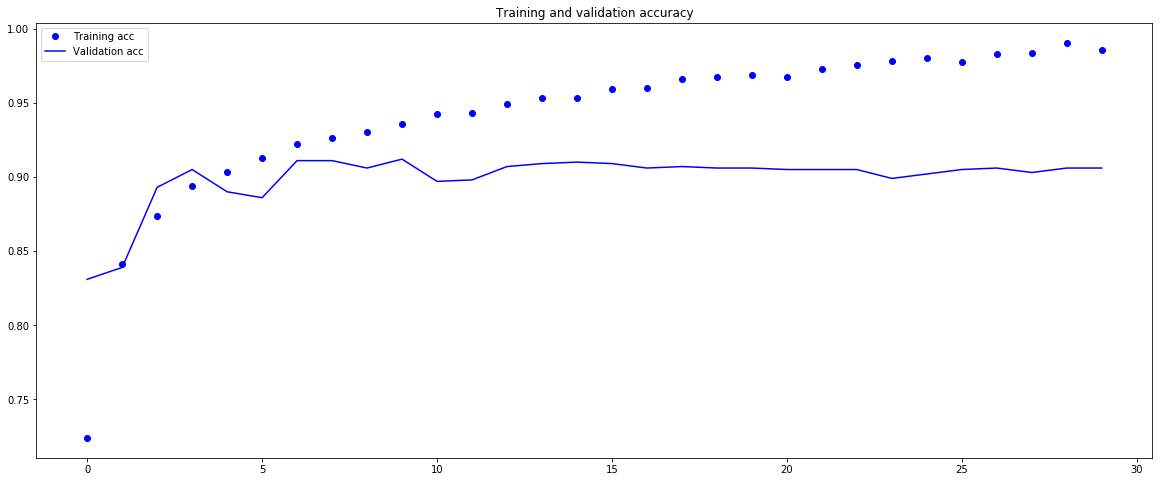

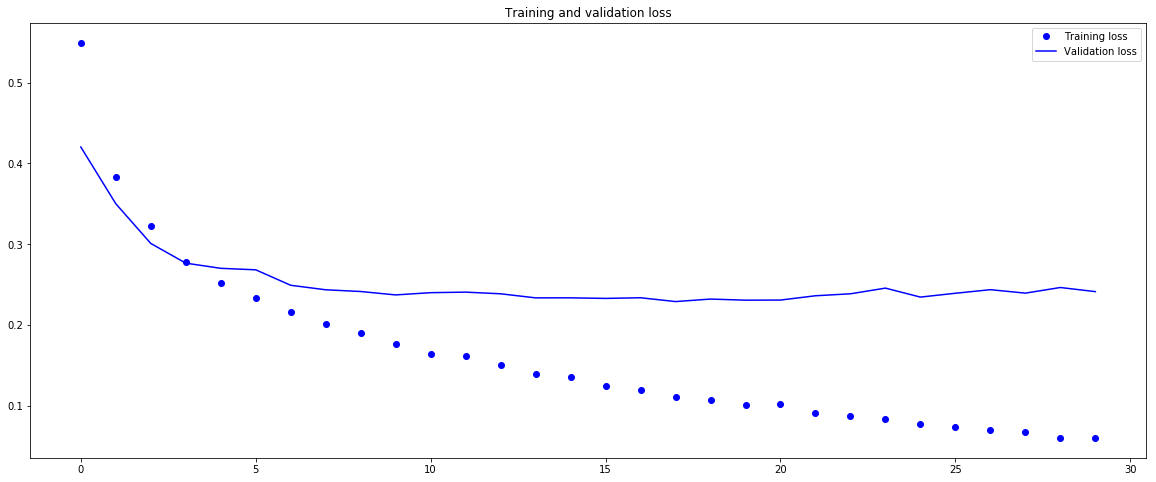

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(20, 8))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(20, 8))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
from keras import models
from keras import layers

In [17]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total para

In [19]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수: 32


In [20]:
conv_base.trainable = False

In [21]:
print('conv_base를 동결한 후 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결한 후 훈련되는 가중치의 수: 6


In [23]:
from keras.preprocessing.image import ImageDataGenerator

In [24]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

In [25]:
train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지의 크기를 150 × 150로 변경합니다
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하므로 이진 레이블이 필요합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [26]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [27]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/30
 - 22s - loss: 0.6189 - acc: 0.6390 - val_loss: 0.4425 - val_acc: 0.8530
Epoch 2/30
 - 20s - loss: 0.4865 - acc: 0.7645 - val_loss: 0.3605 - val_acc: 0.8730
Epoch 3/30
 - 19s - loss: 0.4216 - acc: 0.8050 - val_loss: 0.3174 - val_acc: 0.8710
Epoch 4/30
 - 19s - loss: 0.3677 - acc: 0.8330 - val_loss: 0.3024 - val_acc: 0.8670
Epoch 5/30
 - 19s - loss: 0.3553 - acc: 0.8390 - val_loss: 0.2801 - val_acc: 0.8840
Epoch 6/30
 - 19s - loss: 0.3238 - acc: 0.8585 - val_loss: 0.2670 - val_acc: 0.9000
Epoch 7/30
 - 19s - loss: 0.3218 - acc: 0.8605 - val_loss: 0.2618 - val_acc: 0.9000
Epoch 8/30
 - 18s - loss: 0.3046 - acc: 0.8715 - val_loss: 0.2639 - val_acc: 0.8890
Epoch 9/30
 - 19s - loss: 0.3131 - acc: 0.8630 - val_loss: 0.2525 - val_acc: 0.9020
Epoch 10/30
 - 19s - loss: 0.3021 - acc: 0.8675 - val_loss: 0.2472 - val_acc: 0.9020
Epoch 11/30
 - 19s - loss: 0.2851 - acc: 0.8745 - val_loss: 0.2467 - val_acc: 0.9020
Epoch 12/30
 - 19s - loss: 0.2769 - acc: 0.8770 - val_loss: 0.2412 - val_a

In [28]:
model.save('./models/cats_and_dogs_small_3.h5')

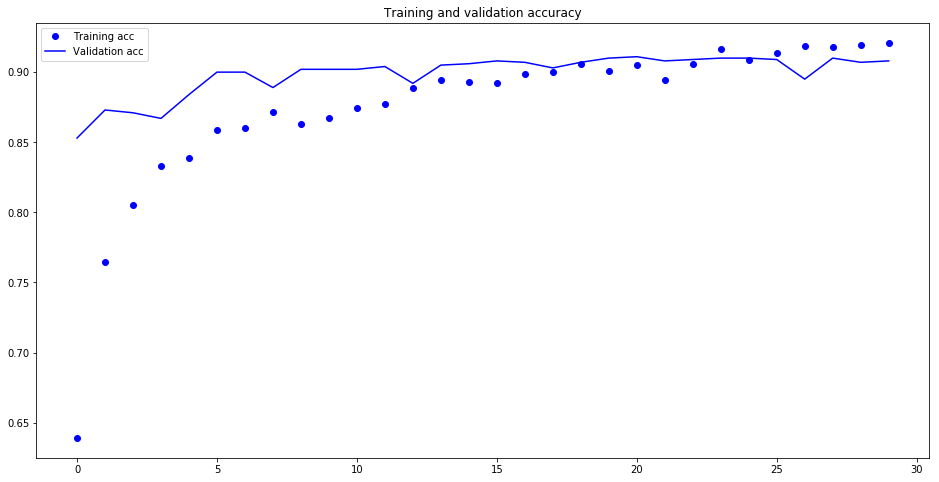

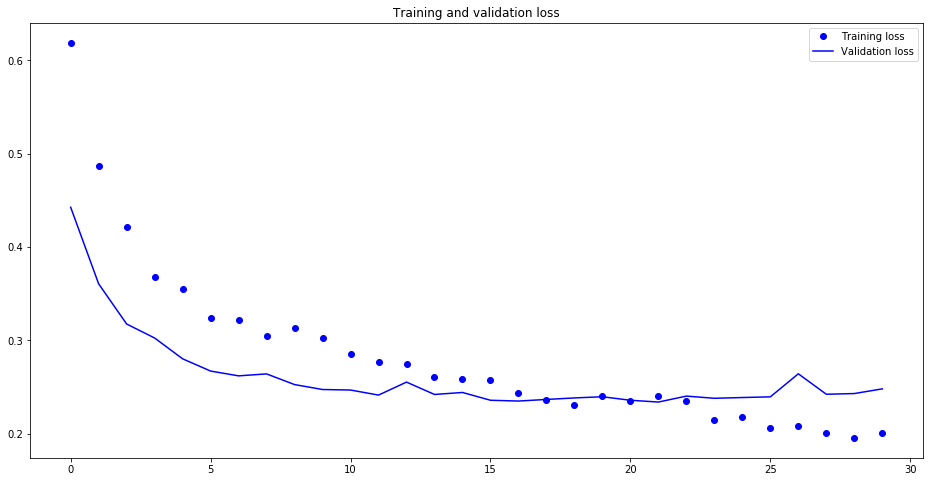

In [29]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(16, 8))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(16, 8))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [30]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [47]:
for layer in conv_base.layers:

    if str(layer.name).startswith('block5_conv1'):
        layer.trainable = True
    else:
        layer.trainable = False
        
    print(layer.trainable, layer.name)

False input_1
False block1_conv1
False block1_conv2
False block1_pool
False block2_conv1
False block2_conv2
False block2_pool
False block3_conv1
False block3_conv2
False block3_conv3
False block3_pool
False block4_conv1
False block4_conv2
False block4_conv3
False block4_pool
True block5_conv1
False block5_conv2
False block5_conv3
False block5_pool


In [46]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [48]:
'''
학습률을 낮춘 RMSProp 옵티마이저를 사용합니다. 
학습률을 낮추는 이유는 미세 조정하는 세 개의 층에서 학습된 표현을 조금씩 수정하기 위해서입니다. 
변경량이 너무 크면 학습된 표현에 나쁜 영향을 끼칠 수 있습니다.
'''

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5), # 학습률 변경
              metrics=['acc'])

In [49]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total para

In [50]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 22s 222ms/step - loss: 0.0732 - acc: 0.9730 - val_loss: 0.3523 - val_acc: 0.8980
Epoch 2/100
100/100 [==============================] - 20s 196ms/step - loss: 0.0587 - acc: 0.9805 - val_loss: 0.3378 - val_acc: 0.9080
Epoch 3/100
100/100 [==============================] - 19s 194ms/step - loss: 0.0748 - acc: 0.9730 - val_loss: 0.3434 - val_acc: 0.9040
Epoch 4/100
100/100 [==============================] - 20s 197ms/step - loss: 0.0695 - acc: 0.9745 - val_loss: 0.3561 - val_acc: 0.8990
Epoch 5/100
100/100 [==============================] - 20s 196ms/step - loss: 0.0801 - acc: 0.9720 - val_loss: 0.3580 - val_acc: 0.8970
Epoch 6/100
100/100 [==============================] - 19s 194ms/step - loss: 0.0683 - acc: 0.9730 - val_loss: 0.3553 - val_acc: 0.9030
Epoch 7/100
100/100 [==============================] - 19s 193ms/step - loss: 0.0673 - acc: 0.9745 - val_loss: 0.3789 - val_acc: 0.8980
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 20s 195ms/step - loss: 0.0522 - acc: 0.9845 - val_loss: 0.4158 - val_acc: 0.8970
Epoch 62/100
100/100 [==============================] - 19s 193ms/step - loss: 0.0506 - acc: 0.9830 - val_loss: 0.4378 - val_acc: 0.8920
Epoch 63/100
100/100 [==============================] - 19s 195ms/step - loss: 0.0468 - acc: 0.9855 - val_loss: 0.3917 - val_acc: 0.8980
Epoch 64/100
100/100 [==============================] - 19s 194ms/step - loss: 0.0484 - acc: 0.9810 - val_loss: 0.4107 - val_acc: 0.9000
Epoch 65/100
100/100 [==============================] - 20s 196ms/step - loss: 0.0403 - acc: 0.9905 - val_loss: 0.4095 - val_acc: 0.8960
Epoch 66/100
100/100 [==============================] - 19s 193ms/step - loss: 0.0441 - acc: 0.9840 - val_loss: 0.4024 - val_acc: 0.9020
Epoch 67/100
100/100 [==============================] - 19s 195ms/step - loss: 0.0571 - acc: 0.9780 - val_loss: 0.4261 - val_acc: 0.8960
Epoch 68/100
100/100 [===================

In [51]:
model.save('./models/cats_and_dogs_small_5.h5')

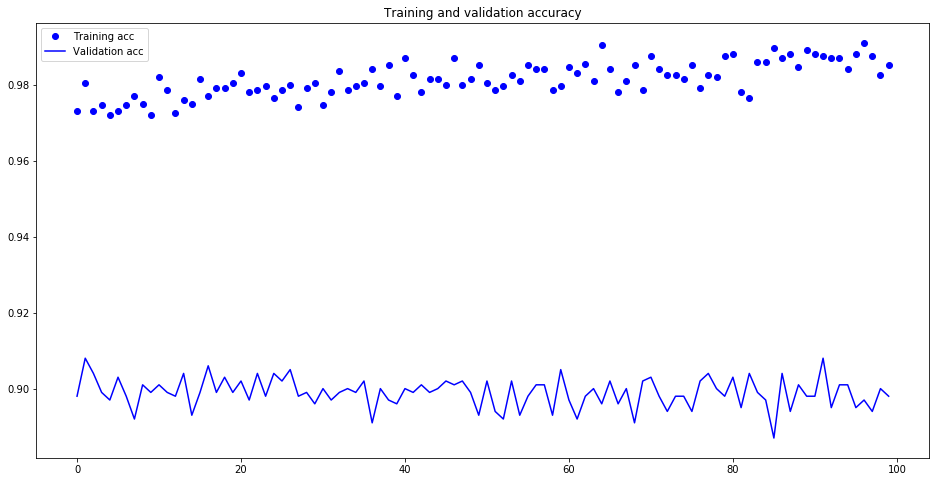

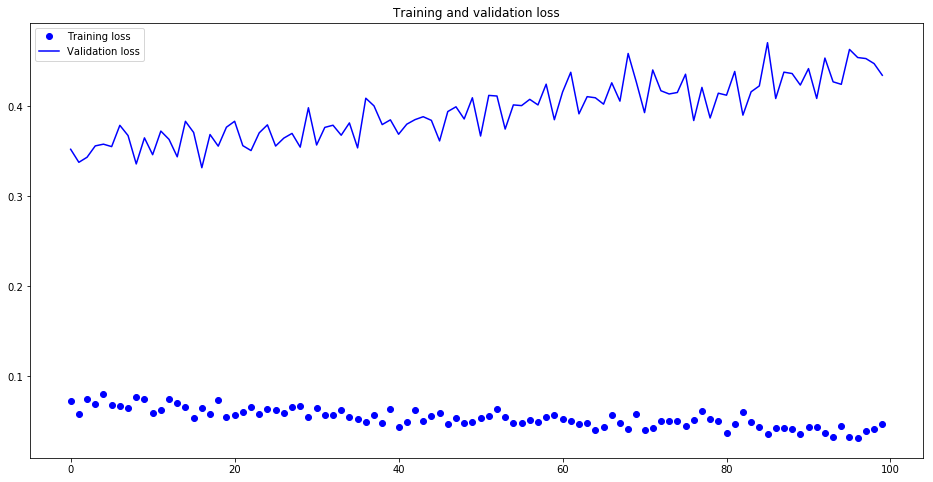

In [52]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(16, 8))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(16, 8))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [53]:
'''
지수 이동 평균으로 정확도와 손실 값을 부드럽게 표현할 수 있습니다. 
'''

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

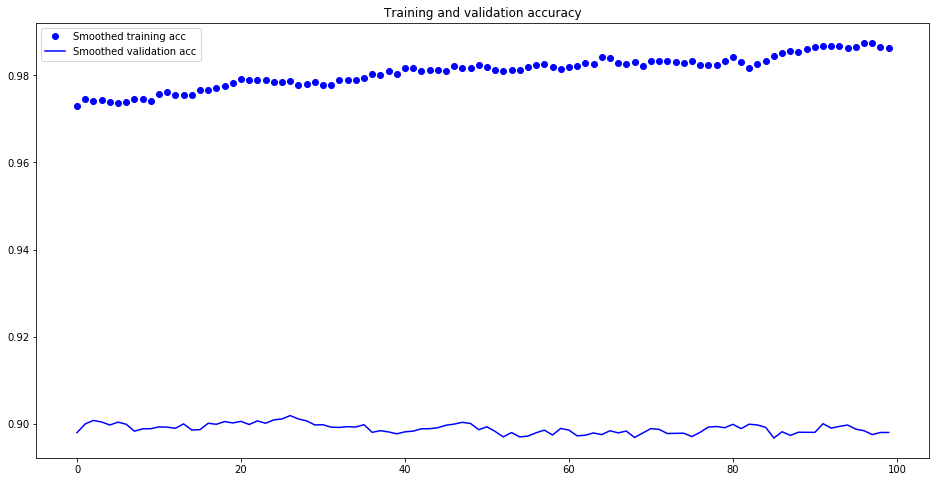

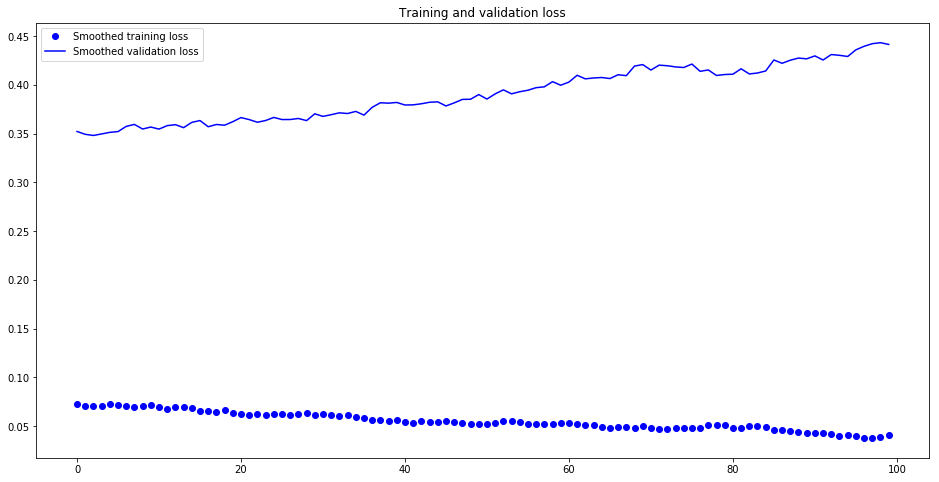

In [54]:
plt.figure(figsize=(16, 8))

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(16, 8))

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [55]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 1000 images belonging to 2 classes.


In [44]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)
print('test loss:', test_loss)

test acc: 0.9099999952316284
test loss: 0.3162320083938539


In [56]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test5 acc:', test_acc)
print('test5 loss:', test_loss)

test5 acc: 0.9099999928474426
test5 loss: 0.3921926775947213
